In [14]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

DEFAULT_SEED = 42

from gaussian import MultivariateNormal, DynamicMultivariateNormal, VarianceExploding, VariancePreserving, SubVariancePreserving
from numerical import EulerSolver, BroydenSolver

In [2]:
num_sides = 6
th = 2.0 * np.pi / num_sides
rot_th = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])

var = np.diag([5.0, 0.5])
mean = np.array([0.0, -10.0])
mean_offset = np.array([20.0, 10.0])
norms = []
for _ in range(num_sides):
    norms.append(DynamicMultivariateNormal(2, mean + mean_offset, var))
    var = rot_th @ var @ rot_th.T
    mean = rot_th @ mean

In [ ]:
def plot_simulation(mix, t, x, show_every=50):
    num_plots = (len(t) - 1) // show_every + 1
    fig, ax = plt.subplots(1, num_plots, figsize=(15, 3))

    for i in range(num_plots):
        si = i * show_every
        ti = t[si]
        xi = x[:, si, :]

        x1_cont = np.linspace(xi[:, 0].min() - 1.0, xi[:, 0].max() + 1.0, 200)
        x2_cont = np.linspace(xi[:, 1].min() - 1.0, xi[:, 1].max() + 1.0, 200)
        x_cont = np.stack(np.meshgrid(x1_cont, x2_cont), -1)
        x1_quiv = x1_cont[5::10]
        x2_quiv = x2_cont[5::10]
        x_quiv = np.stack(np.meshgrid(x1_quiv, x2_quiv), -1)
        score, div_score = mix.score_with_div(ti, x_quiv)
    
        ax[i].scatter(*xi.T, s=1)
        ax[i].contour(x_cont[:, :, 0], x_cont[:, :, 1], np.log(1e-8 + mix.density(ti, x_cont)), levels=10, alpha=0.5, cmap="plasma")
        ax[i].quiver(x_quiv[:, :, 0], x_quiv[:, :, 1], score[:, :, 0], score[:, :, 1], div_score, alpha=0.8)
    return fig, ax

### Euler method

/home/ben/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `vectorized`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

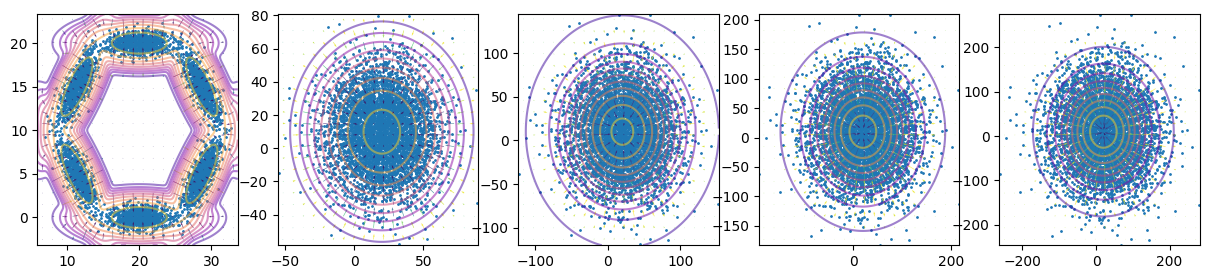

In [4]:
t_min = 1e-6
tf = 80.0
mix = VarianceExploding(tuple(norms))

def forward_ode(t, x_flat):
    x = x_flat.reshape(-1, mix.dim)
    return mix.ode(t, x).flatten()

num_sample = 5000
num_save = 500

x = mix.sample(num_sample)

sol = solve_ivp(forward_ode, (t_min, tf), x.flatten(), method=EulerSolver, nt=num_save)
x = sol.y.reshape(num_sample, mix.dim, num_save + 1).transpose(0, 2, 1)
plot_simulation(mix, sol.t, x, show_every=120)

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

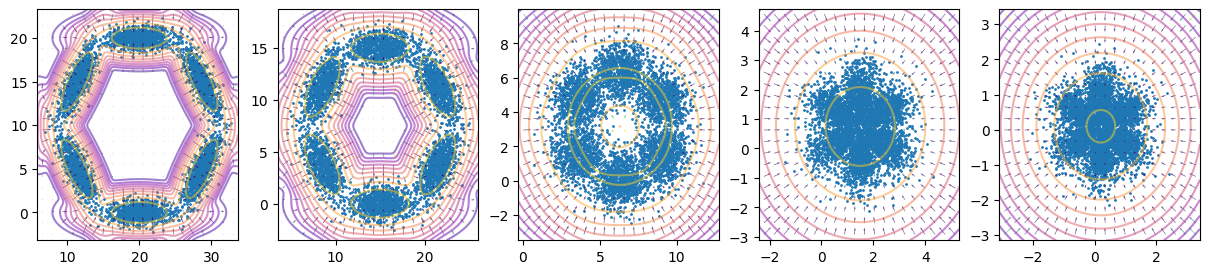

In [5]:
t_min = 1e-6
tf = 1.0
mix = VariancePreserving(tuple(norms))

def forward_ode(t, x_flat):
    x = x_flat.reshape(-1, mix.dim)
    return mix.ode(t, x).flatten()

num_sample = 5000
num_save = 500

x = mix.sample(num_sample)

sol = solve_ivp(forward_ode, (t_min, tf), x.flatten(), method=EulerSolver, nt=num_save)
x = sol.y.reshape(num_sample, mix.dim, num_save + 1).transpose(0, 2, 1)
plot_simulation(mix, sol.t, x, show_every=120)

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

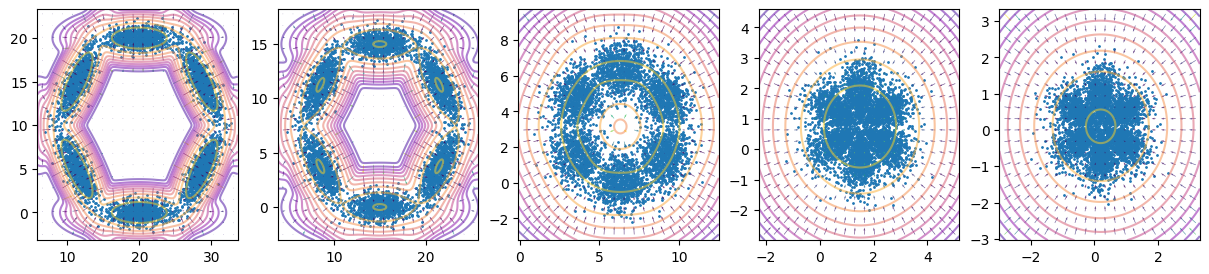

In [6]:
t_min = 1e-6
tf = 1.0
mix = SubVariancePreserving(tuple(norms))

def forward_ode(t, x_flat):
    x = x_flat.reshape(-1, mix.dim)
    return mix.ode(t, x).flatten()

num_sample = 5000
num_save = 500

x = mix.sample(num_sample)

sol = solve_ivp(forward_ode, (t_min, tf), x.flatten(), method=EulerSolver, nt=num_save)
x = sol.y.reshape(num_sample, mix.dim, num_save + 1).transpose(0, 2, 1)
plot_simulation(mix, sol.t, x, show_every=120)

### Broyden method

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

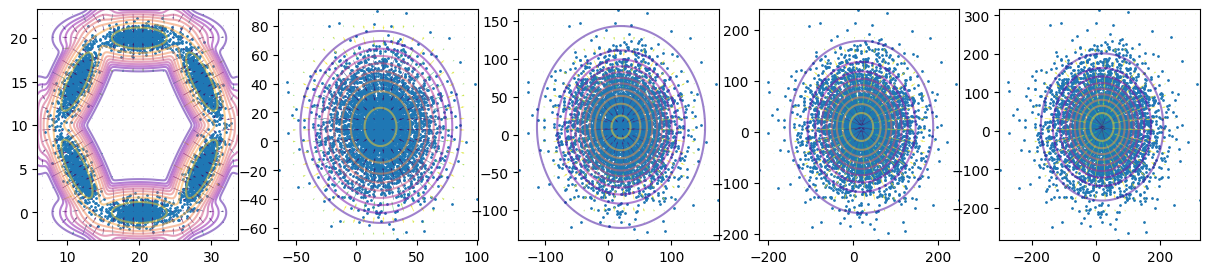

In [7]:
t_min = 1e-6
tf = 80.0
mix = VarianceExploding(tuple(norms))

num_sample = 5000
num_save = 500

x = mix.sample(num_sample)

sol = BroydenSolver(mix.ode, t_min, tf, num_save)
t, x = sol(x)
plot_simulation(mix, t, x, show_every=120)

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

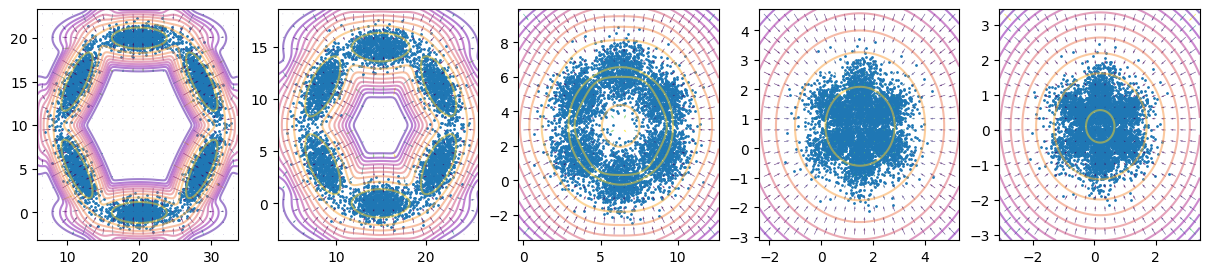

In [8]:
t_min = 1e-6
tf = 1.0
mix = VariancePreserving(tuple(norms))

num_sample = 5000
num_save = 500

x = mix.sample(num_sample)

sol = BroydenSolver(mix.ode, t_min, tf, num_save)
t, x = sol(x)
plot_simulation(mix, t, x, show_every=120)

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

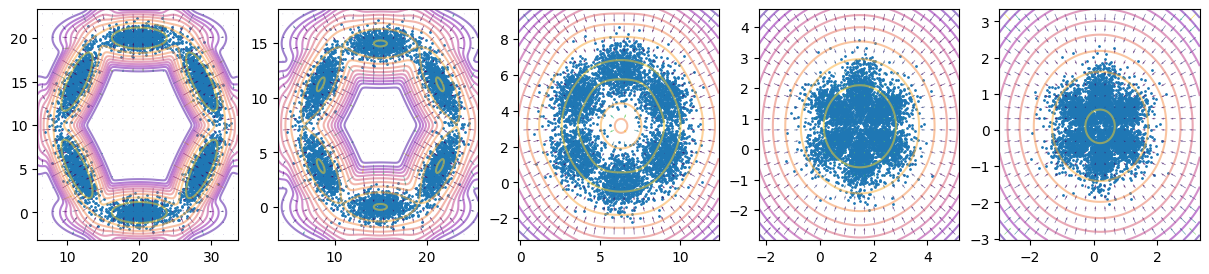

In [9]:
t_min = 1e-6
tf = 1.0
mix = SubVariancePreserving(tuple(norms))

num_sample = 5000
num_save = 500

x = mix.sample(num_sample)

sol = BroydenSolver(mix.ode, t_min, tf, num_save)
t, x = sol(x)
plot_simulation(mix, t, x, show_every=120)

### Negative log-likelihood (Euler)

In [10]:
def compute_nll_euler(mix, prior, n_data=5000, t_min=1e-6, tf=1.0):
    def flat_extended_ode(t, x_cumdiv_flat):
        x, _ = np.split(x_cumdiv_flat.reshape(-1, mix.dim + 1), [mix.dim], -1)
        dx, dlogp = mix.extended_ode(t, x)
        return np.concatenate([dx, dlogp], 1).flatten()

    x_data = mix.sample(n_data)
    delta_logp = np.zeros((n_data, 1))
    x_logp_init = np.concatenate([x_data, delta_logp], axis=1)

    num_save = 500
    sol = solve_ivp(flat_extended_ode, (t_min, tf), x_logp_init.flatten(), method=EulerSolver, nt=num_save)

    x_logp_fin = sol.y[:, -1].reshape(n_data, mix.dim + 1)
    x, delta_logp = np.split(x_logp_fin, [mix.dim], -1)
    prior_fin = np.log(prior.density(x))
    return x, -(delta_logp[:, 0] + prior_fin).mean() / np.log(2.0) / mix.dim

Text(0.5, 1.0, 'NLL: 0.89')

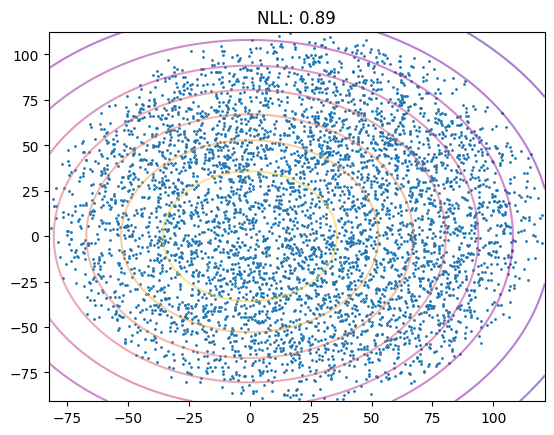

In [11]:
tf = 80.0
mix = VarianceExploding(tuple(norms))
prior = MultivariateNormal(mix.dim, cov=mix.added_noise_sq(tf))
x, nll = compute_nll_euler(mix, prior, tf=tf)
plt.scatter(*x.T, s=1)

x1_cont = np.linspace(x[:, 0].min() - 1.0, x[:, 0].max() + 1.0, 200)
x2_cont = np.linspace(x[:, 1].min() - 1.0, x[:, 1].max() + 1.0, 200)
x_cont = np.stack(np.meshgrid(x1_cont, x2_cont), -1)
plt.contour(x_cont[:, :, 0], x_cont[:, :, 1], prior.density(x_cont), levels=10, alpha=0.5, cmap="plasma")

plt.title(f"NLL: {nll:.2f}")

Text(0.5, 1.0, 'NLL: 3.89')

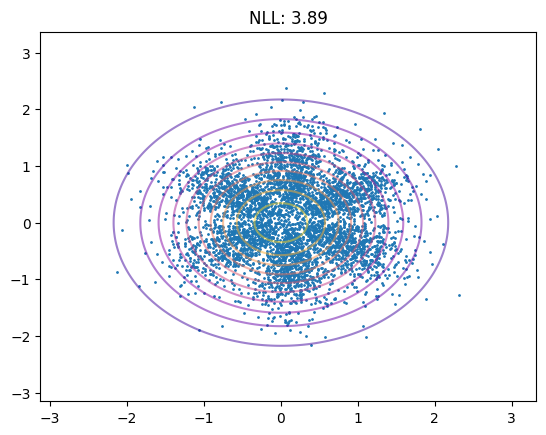

In [12]:
mix = VariancePreserving(tuple(norms))
prior = MultivariateNormal(mix.dim)
x, nll = compute_nll_euler(mix, prior)
plt.scatter(*x.T, s=1)

x1_cont = np.linspace(x[:, 0].min() - 1.0, x[:, 0].max() + 1.0, 200)
x2_cont = np.linspace(x[:, 1].min() - 1.0, x[:, 1].max() + 1.0, 200)
x_cont = np.stack(np.meshgrid(x1_cont, x2_cont), -1)
plt.contour(x_cont[:, :, 0], x_cont[:, :, 1], prior.density(x_cont), levels=10, alpha=0.5, cmap="plasma")

plt.title(f"NLL: {nll:.2f}")

Text(0.5, 1.0, 'NLL: 3.93')

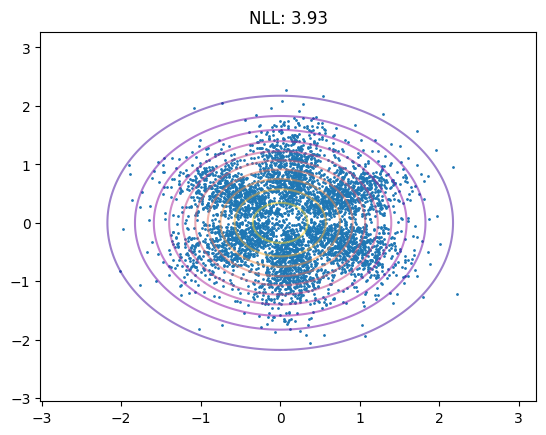

In [13]:
mix = SubVariancePreserving(tuple(norms))
prior = MultivariateNormal(mix.dim)
x, nll = compute_nll_euler(mix, prior)
plt.scatter(*x.T, s=1)

x1_cont = np.linspace(x[:, 0].min() - 1.0, x[:, 0].max() + 1.0, 200)
x2_cont = np.linspace(x[:, 1].min() - 1.0, x[:, 1].max() + 1.0, 200)
x_cont = np.stack(np.meshgrid(x1_cont, x2_cont), -1)
plt.contour(x_cont[:, :, 0], x_cont[:, :, 1], prior.density(x_cont), levels=10, alpha=0.5, cmap="plasma")

plt.title(f"NLL: {nll:.2f}")